Importing Libraries

In [70]:
import pandas as pd
import numpy as np
import pylab as pl
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

Using Kaggle API to fetch dataset from Kaggle

In [71]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"prodigiousphoton","key":"cea6c912a484a4ee07cf635547372b98"}'}

In [72]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [73]:
! chmod 600 ~/.kaggle/kaggle.json


In [74]:
!kaggle datasets download -d neuromusic/avocado-prices

avocado-prices.zip: Skipping, found more recently modified local copy (use --force to force download)


In [75]:
!unzip /content/avocado-prices.zip

Archive:  /content/avocado-prices.zip
replace avocado.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: avocado.csv             


Reading and Understanding the data

In [76]:
data = pd.read_csv('/content/avocado.csv')

In [77]:
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [78]:
data.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    18249 non-null  int64         
 1   Date          18249 non-null  datetime64[ns]
 2   AveragePrice  18249 non-null  float64       
 3   Total Volume  18249 non-null  float64       
 4   4046          18249 non-null  float64       
 5   4225          18249 non-null  float64       
 6   4770          18249 non-null  float64       
 7   Total Bags    18249 non-null  float64       
 8   Small Bags    18249 non-null  float64       
 9   Large Bags    18249 non-null  float64       
 10  XLarge Bags   18249 non-null  float64       
 11  type          18249 non-null  object        
 12  year          18249 non-null  int64         
 13  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 1.9+ MB


In [80]:
data.shape

(18249, 14)

Checking for Null Values

In [81]:
data.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

Visualizing the Data

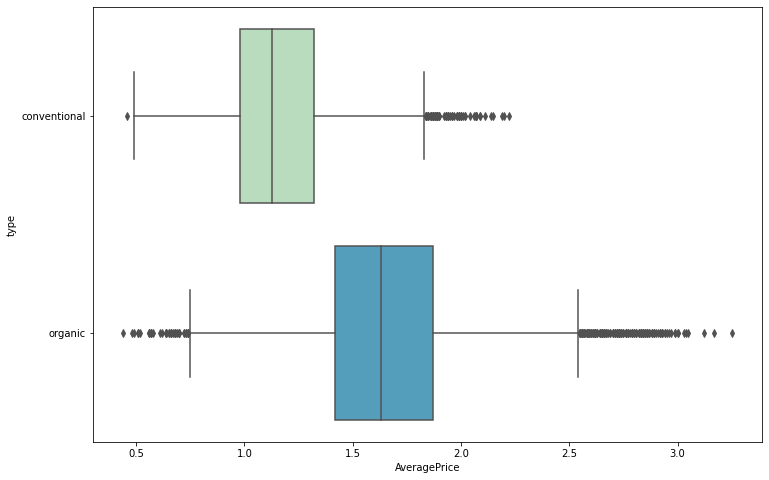

In [82]:
sns.boxplot(y="type", x="AveragePrice", data=data, palette = 'GnBu')
plt.show()

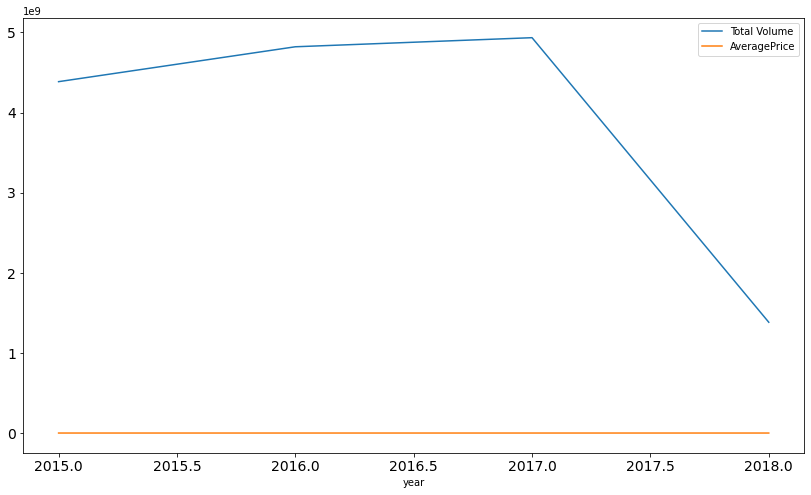

In [83]:
Year = data[['Total Volume' ,'AveragePrice']].groupby(data.year).sum()
Year.plot(kind='line', fontsize = 14,figsize=(14,8))
plt.show()

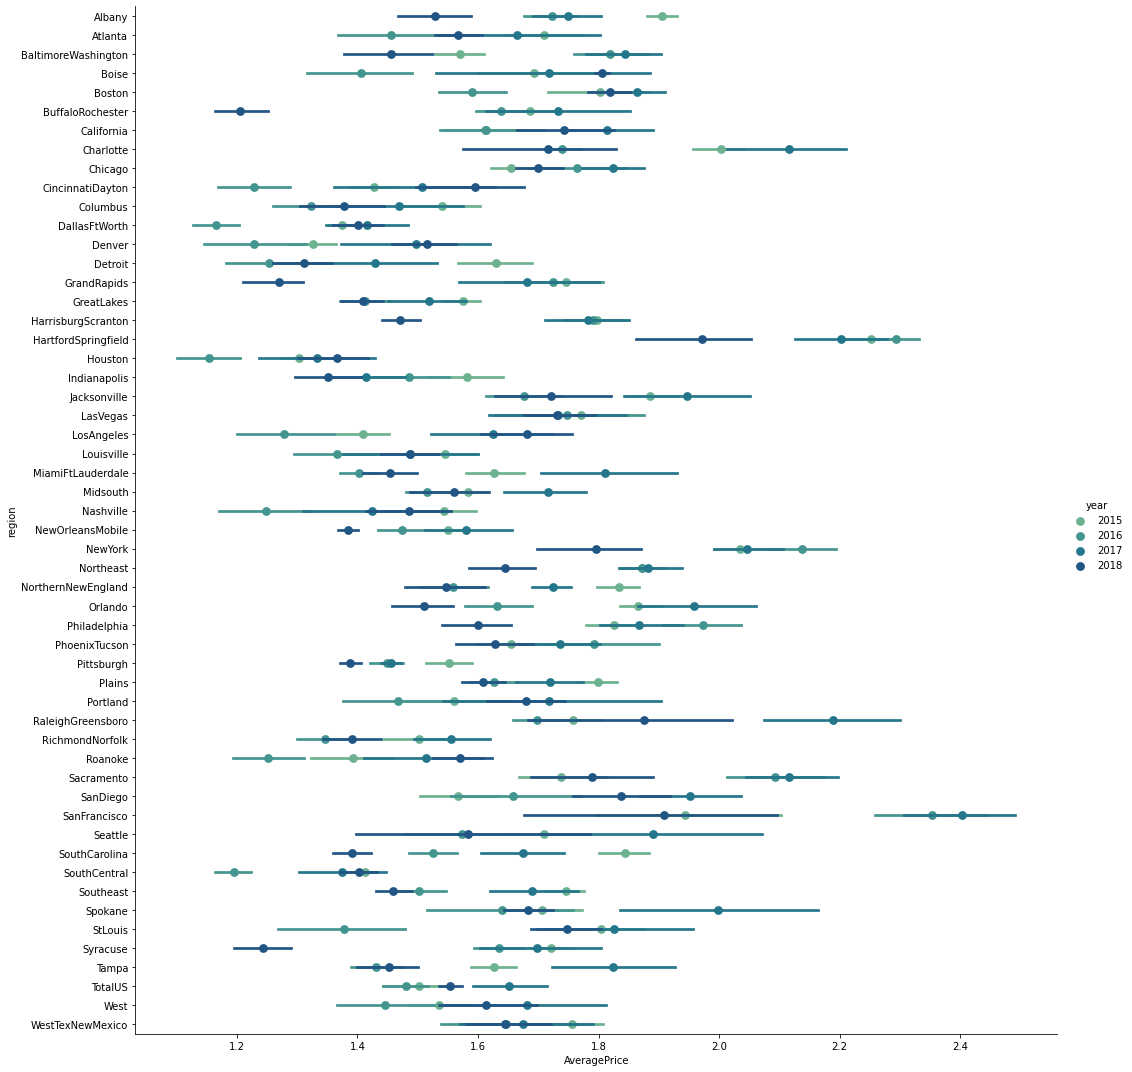

In [84]:
mask = data['type']=='organic'
g = sns.factorplot('AveragePrice','region',data=data[mask],
                   hue='year',
                   size = 15,
                   palette='crest',
                   join=False,
              )
plt.show()

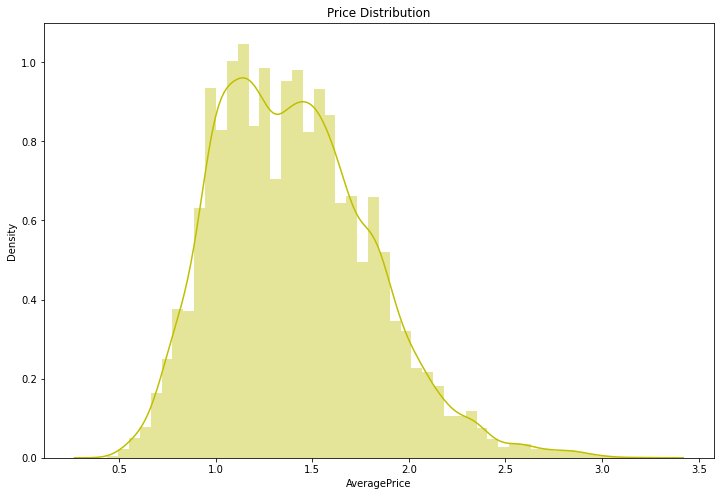

In [85]:
plt.title("Price Distribution")
ax = sns.distplot(data["AveragePrice"], color = 'y')
plt.show()

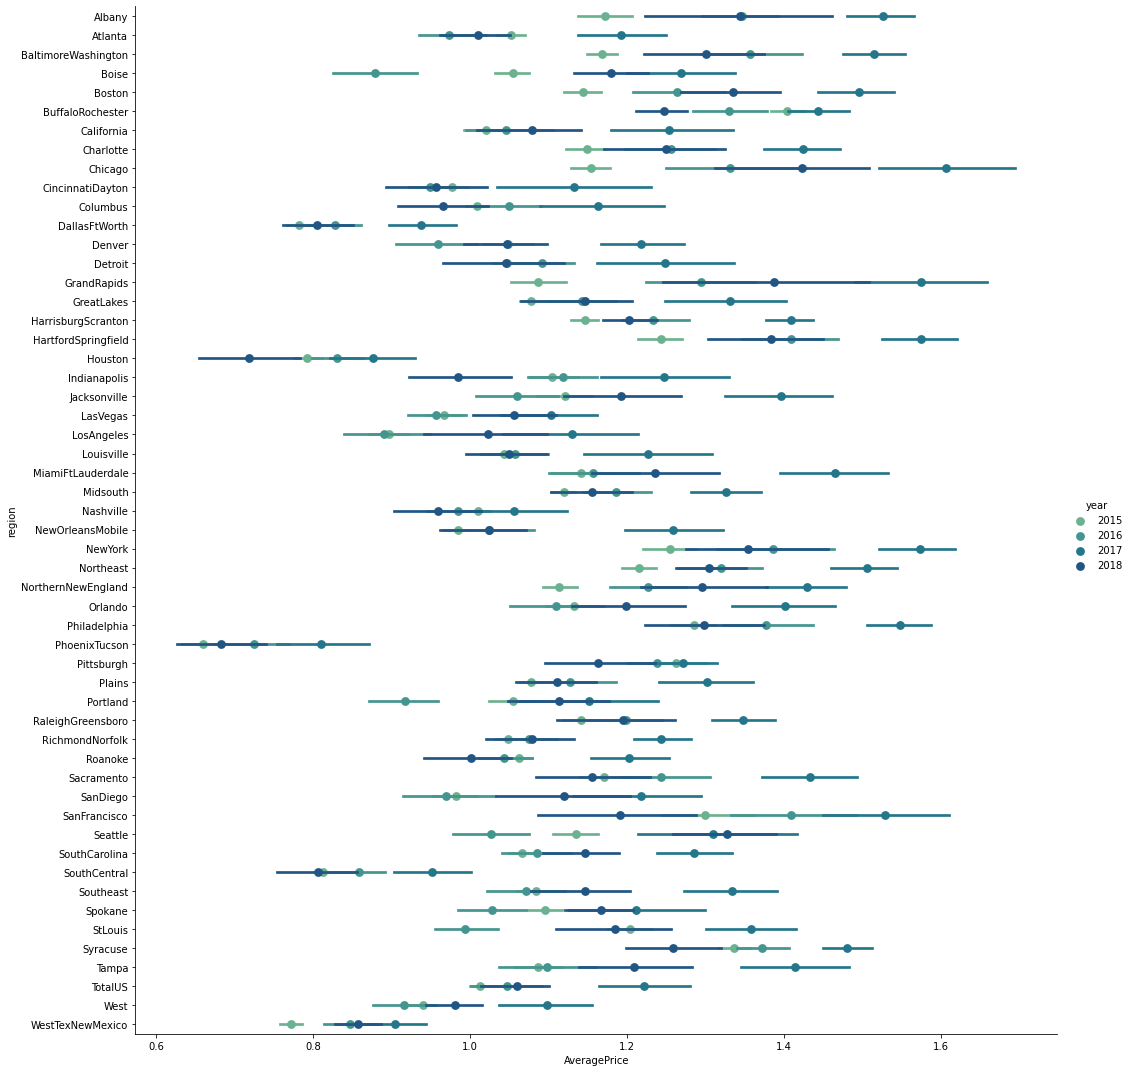

In [86]:
mask = data['type']=='conventional'
g = sns.factorplot('AveragePrice','region',data=data[mask],
                   hue='year',
                   size = 15,
                   palette='crest',
                   join=False,
              )
plt.show()

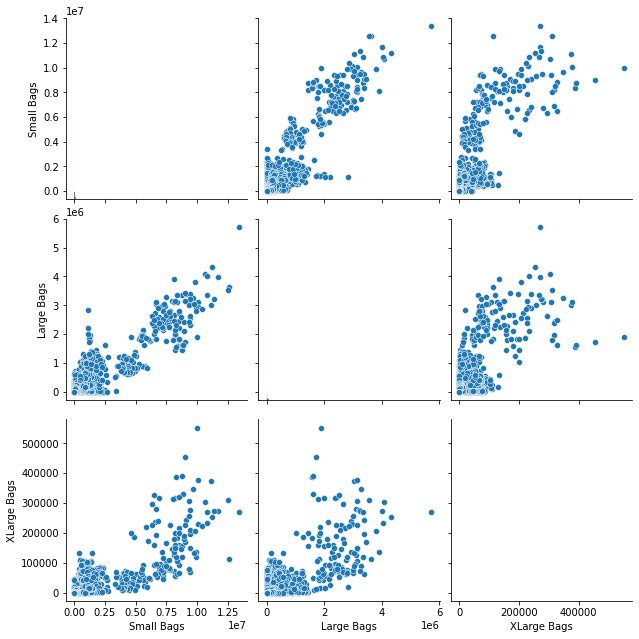

In [87]:
sns.pairplot(data.iloc[:,8:11], palette="crest",height=3)

Applying Regression Models on the dataset


In [88]:
y = data.AveragePrice	
data.drop(['AveragePrice','Date'], axis=1, inplace=True)

In [89]:
x_train,x_test,y_train,y_test =  train_test_split(data, y, train_size=0.7,test_size=0.3, random_state=0)

In [90]:
s = (x_train.dtypes == 'object')
object_cols = list(s[s].index)

n = (x_train.dtypes == ('float64','int64'))
numerical_cols = list(n[n].index)

Using One Hot Encoder

In [91]:
#using One Hot Encoder to make the categorical columns usable

oneHot = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
oneHottrain = pd.DataFrame(oneHot.fit_transform(x_train[object_cols]))
oneHottest = pd.DataFrame(oneHot.transform(x_test[object_cols]))

#reattaching index since OneHotEncoder removes them:
oneHottrain.index = x_train.index
oneHottest.index = x_test.index 

#dropping the old categorical columns:
cattraincol = x_train.drop(object_cols, axis=1)
cattestcol = x_test.drop(object_cols, axis=1)

#concatenating the new columns:
x_train = pd.concat([cattraincol, oneHottrain], axis=1)
x_test = pd.concat([cattestcol, oneHottest], axis=1)

In [92]:
data.head()

,Unnamed: 0,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [93]:
trainf = x_train.values
testf = x_test.values

minmax = MinMaxScaler()

x_train = minmax.fit_transform(trainf)
x_test = minmax.transform(testf)

#defining a way to find Mean Absolute Percentage Error:
def PercentError(preds, ytest):
  error = abs(preds - ytest)

  errorp = np.mean(100 - 100*(error/ytest))

  print('the accuracy is:', errorp)

Random Forest Regressor Model

In [94]:
#implementing the algo:
model = RandomForestRegressor(n_estimators=100, random_state=0, verbose=1)

#fitting the data to random forest regressor:
model.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.0s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=1, warm_start=False)

In [95]:
#predicting the test dataset:
preds = model.predict(x_test)
PercentError(preds, y_test)

the accuracy is: 93.4669089482996


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Linear Regression

In [96]:
LinearModel = LinearRegression()
LinearModel.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [97]:
LinearPredictions = LinearModel.predict(x_test)
PercentError(LinearPredictions, y_test)

the accuracy is: 85.05850428803282


Ridge Regression

In [98]:
RidgeModel = Ridge()
RidgeModel.fit(x_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [99]:
#predicting on the test dataset:
RidgePredictions = RidgeModel.predict(x_test)
PercentError(RidgePredictions, y_test)

the accuracy is: 85.0728929102772


## Thank You